<font size=5><center>Water Quality Prediction</center></font>
"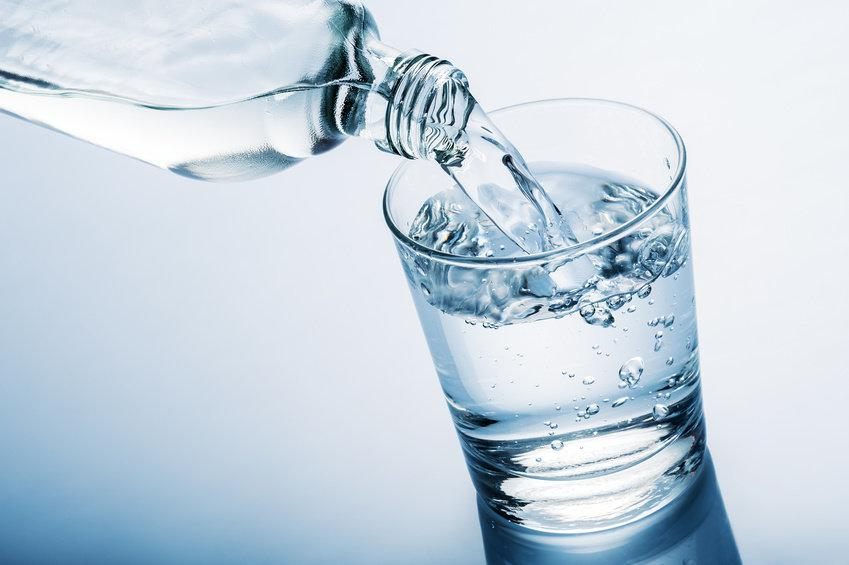

<a class="anchor" id="toc"></a>
<div style="background: #f9f9f9 none repeat scroll 0 0;border: 1px solid #aaa;display: table;font-size: 95%;margin-bottom: 1em;padding: 20px;width: 600px;">
<h1>Contents</h1>
<ul style="font-weight: 700;text-align: left;list-style: outside none none !important;">
<li style="list-style: outside none none !important;font-size:17px"><a href="#1">1 Introduction</a></li>
    
<li style="list-style: outside none none !important;font-size:17px"><a href="#2">2 Understanding data</a></li>

<li style="list-style: outside none none !important;font-size:17px"><a href="#3">3 Exploratory Data Analysis</a></li>
<li style="list-style: outside none none !important;font-size:17px"><a href="#3">4 Data Prepration and Feature Engineering</a></li>
<li style="list-style: outside none none !important;font-size:17px"><a href="#4">5 Modelling</a></li>
    <ul style="font-weight: 700;text-align: left;list-style: outside none none !important;">  
        
        

</ul>
</div>

## 1. Introduction

### Let's learn some useful stuff about our features first:

1. **ph**: pH of 1. water (0 to 14).

2. **Hardness**: Capacity of water to precipitate soap in mg/L.

3. **Solids**: Total dissolved solids in ppm.

4. **Chloramines**: Amount of Chloramines in ppm.

5. **Sulfate**: Amount of Sulfates dissolved in mg/L.

6. **Conductivity**: Electrical conductivity of water in μS/cm.

7. **Organic_carbon**: Amount of organic carbon in ppm.

8. **Trihalomethanes**: Amount of Trihalomethanes in μg/L.

9. **Turbidity**: Measure of light emiting property of water in NTU.

10. **Potability**: Indicates if water is safe for human consumption. Potable - 1 and Not potable - 0

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

df = pd.read_csv('../input/water-potability/water_potability.csv')

## 2. Understanding Data

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.columns

In [ ]:
df.describe()

## 3. Exploratory Data Analysis

First of all i need to point out what is actually the point of doing full and comprehensive EDA on our data?
There are many reasons for that. For start, it's important to mention that in order to do a good prediction we need to know our data based on our domain knowledge.
the most import reasons of EDA:
* It exposes trends, patterns, and relationships that are not readily apparent
* Getting a “feel” for this critical information can help you detect mistakes, debunk assumptions, and understand the relationships between different key variables
* Better insights may eventually lead to do percise feature engineering and better selection of an appropriate predictive model

### Now let's do it step by step. First lets look at our label in order find out see if it's balanced or not.

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,8))
df.Potability.value_counts().plot(kind ='pie', ax=ax[0])
# ax[0].pie(x=df['Potability'])
sns.countplot(data=df,x='Potability',ax=ax[1])
plt.show()

**Description: ** our data a little bit unbalanced. we need to consider this in our modeling later.

Let's try to know our features better...

In [ ]:
plt.figure(figsize=(10,10))

for ax,col in enumerate(df.columns[:9]):
    plt.subplot(3,3,ax+1)
    plt.title(f'Distribution of {col}')
    sns.kdeplot(x=df[col], fill=True, alpha=0.4, hue = df.Potability, multiple='stack')
plt.tight_layout()

In [ ]:
plt.figure(figsize=(10,10))

for ax,col in enumerate(df.columns[:9]):
    plt.subplot(3,3,ax+1)
    plt.title(f'Distribution of {col}')
    sns.boxplot(data=df, x='Potability',y=df[col])
    plt.legend(prop=dict(size=10))
plt.tight_layout()

In [ ]:
sns.pairplot(data=df,hue='Potability')

In [ ]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(8, 8))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=colormap, linewidths=.5, annot=True, fmt=".2f", mask=dropSelf)
plt.show()

### From Above charts we can confirm:
1. Heatmap, pairplot: there is not any strong corrolation between our features. Also there's not any comultinearity.
2. Boxplot: There isn't any significant difference between potable and not potable in different feature. There are some outliers too, but i leave them to be in dataset. Removing them again can be a good option depends on the domain knowledge.
3. kdeplot: some features like Solids might be a little skewed but i guess that's not a big deal in this case.

## 4. Data Prepration and Feature Engineering

### In this part we need to deal with two main problems. First, as we saw befor our labels are imbalanced. So let's try to balance them. shall we? =)

In [ ]:
df['Potability'].value_counts()

You can balance your data by resampling them. The followings are two different techniques for resampling:
* Upsampling (increase your minority class)
* Downsample (decrease your majority class)

In [ ]:
from sklearn.utils import resample
from sklearn.utils import shuffle

not_potable  = df[df['Potability']==0]   
potable = df[df['Potability']==1]  

new = resample(potable, replace = True, n_samples = 1998) 
df = pd.concat([not_potable, new])

df = shuffle(df)

In [ ]:
df.Potability.value_counts().plot(kind ='pie')

Congrats! Our data is now balances. So let's fix our nex problem. Let's fix our missing data 

In [ ]:
df.isnull().sum()

### for the second problem(missing values), we got two options:
* drop all the NaN values, cause referring to our domain knowledge it's important to have true values in our features so that we don't get more FP(False Posivite)
* We can describe our TN and FP. Maybe we can use median for our missing data
#### I will do the second solution for some practise :)) but remember it depends on the domain knowledge to choose the right solution!
#### As we saw our boxplot of features, median of both potable and not potable data are almost the same in any feature. so we can use the overall median of each feature for NaN values.

In [ ]:
for cols in ['ph','Sulfate','Trihalomethanes']:
    df[cols]=df[cols].fillna(df.groupby(['Potability'])[cols].transform('median'))

In [ ]:
df.isnull().sum().any()

## 5. Modeling

I decided to use Logistic Regression, KNN and Desicion Tree for this dataset. Although there others algorithms to use. So let me know your opinion in the comment section =))

In [ ]:
from sklearn.model_selection import train_test_split
X = df.drop('Potability',axis=1)
y = df['Potability']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=101)

### 5.1 Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# FIRST SCALE OUR DATA
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


log_model = LogisticRegression(solver='saga', multi_class='ovr', max_iter=5000)

penalty = ['l1','l2','elasticnet']
l1_ratio = np.linspace(0,1,20)
C = np.logspace(0,10,20)
param_grid = { 'penalty':penalty, 'l1_ratio':l1_ratio, 'C':C }

grid_model = GridSearchCV(log_model, param_grid=param_grid)
grid_model.fit(X_train, y_train)

In [ ]:
grid_model.best_params_

In [ ]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix,classification_report
y_prediction = grid_model.predict(X_test)
accuracy_score(y_test,y_prediction)

In [ ]:
plot_confusion_matrix(grid_model, X_test, y_test)

In [ ]:
print(classification_report(y_test,y_prediction))

**Result: ** As we saw we use grid search and logistic regression and the result wasn't quite satisfying

### 5.2 KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
test_error_rates = [] 

for k in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train,y_train)
    
    y_pred = knn_model.predict(X_test)
    test_error = 1 - accuracy_score(y_test, y_pred)
    
    test_error_rates.append(test_error)

Let's first use the elbow method to find out the best value for k

In [ ]:
plt.plot(range(1,30),test_error_rates)
plt.ylabel('ERROR RATE')
plt.xlabel('k Neighbor')
plt.show()

Let's try Pipeline and gridsearchCV to find best hyperparameters for our model (I used pipeline for education perpuse. In real life solution it's not necessory for this problem)

In [ ]:
from sklearn.pipeline import Pipeline
scaler = StandardScaler()
knn = KNeighborsClassifier()
operations = [('scaler',scaler),('knn',knn)]
pipe = Pipeline(operations)

k_values = list(range(1,20))

param_grid = { 'knn__n_neighbors': k_values }

full_cv_classifier = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
full_cv_classifier.fit(X_train, y_train)

In [ ]:
full_cv_classifier.best_estimator_.get_params()

In [ ]:
y_pred = full_cv_classifier.predict(X_test)
print(classification_report(y_test,y_pred))

In [ ]:
plot_confusion_matrix(full_cv_classifier, X_test, y_test)

**Result: ** KNN gives us a better result and accuracy! 